In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from scipy.spatial import distance
from sklearn.datasets import make_classification, load_iris, load_digits
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# Adjust size of plots
plt.rcParams['figure.figsize'] = [6, 4]

# Simple example

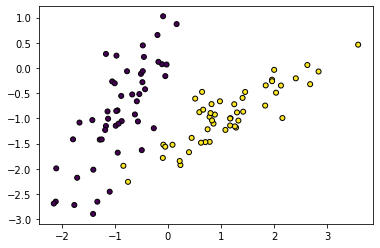

In [2]:
# Make simple example
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, 
                           n_clusters_per_class=1, random_state=5)

# Plot data
plt.scatter(X[:, 0], X[:, 1], c=y, s=25, edgecolor='k')

In [3]:
# Split data in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, shuffle=True, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((70, 2), (30, 2), (70,), (30,))

In [4]:
# Normalize training and test set
scaler =  MinMaxScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# Show min and max of trianing set
(X_train.min(), X_train.max()), (X_train_norm.min(), X_train_norm.max())

((-2.894269721182085, 3.5850647465290626), (0.0, 1.0))

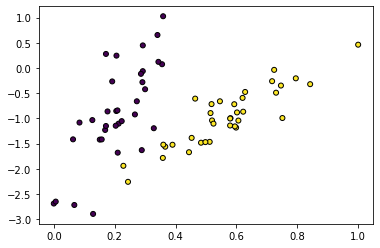

In [5]:
# Plot training data
plt.scatter(X_train_norm[:, 0], X_train[:, 1], c=y_train, s=25, edgecolor='k')

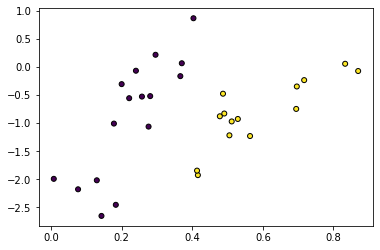

In [6]:
# Plot test data
plt.scatter(X_test_norm[:, 0], X_test[:, 1], c=y_test, s=25, edgecolor='k')

### Custom implementation

In [7]:
def knn(X_train, y_train, X_test, k):
    """Simple k-nearest neighbor algorithm.
    
    Parameters
    ----------
        X_train : ndarray of shape (n_samples, n_features)
            Training input data.
        y_train : ndarray of shape (n_samples,)
            Training class labels.
        X_test : ndarray of shape (n_samples, n_features)
            Test input data.
        k : int
            Number of neighbors.
            
    Returns
    -------
        classes : ndarray of shape (n_samples,)
            Predicted class labels.
    """
    
    # List to save the class predictions
    classes = []
    
    # Compute predictions for every sample
    for x_test in X_test:
        
        # List for distances from the sample to all datapoints
        distances = []
        
        # Compute distances from sample to all datapoints
        for x_train in X_train:
            distances.append(distance.euclidean(x_train, x_test))
        
        # Indices of the k nearest neighbors of the sample 
        neighbors_idx = np.argsort(distances)[:k]
        
        # Classes of the k nearest neighbors of the sample 
        neighbor_classes = y_train[neighbors_idx]
        
        # Most common class of the k nearest neighbors of the sample 
        classes.append(np.bincount(neighbor_classes).argmax())
        
    return np.array(classes)

In [8]:
# Make predictions with custom knn
y_pred = knn(X_train, y_train, X_test, 2)

# Show results
score = np.sum(y_pred == y_test) / len(y_pred)
score

1.0

### Scikit-learn implementation

In [9]:
# Apply k-nearest neighbors from sklearn
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model
knn.fit(X_train_norm, y_train)

# Predict labels
y_pred = knn.predict(X_test_norm)

knn.score(X_test_norm, y_test)

0.9666666666666667

In [10]:
# Paramter grid for knn
param_grid = {
    'n_neighbors': [x for x in range(1,11)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Train grid search cross validation model
grid_search = GridSearchCV(knn, param_grid, cv=10).fit(X_train_norm, y_train)

# Show best estimator
grid_search.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance')

In [11]:
# Show complete cross validation results
# grid_search.cv_results_

In [12]:
# Cross validation for best estimator
scores = cross_val_score(grid_search.best_estimator_, X_train_norm, y_train,
                         cv=10)

# Show cross val scores
scores

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.85714286, 1.        , 1.        , 1.        , 1.        ])

In [13]:
# Show mean and variance of the cross val scores
scores.mean(), scores.std()

(0.9857142857142858, 0.04285714285714287)

In [14]:
# Final evaluation on test set
grid_search.best_estimator_.score(X_test_norm, y_test)

1.0

# Iris dataset

In [15]:
# Load iris dataset
data = load_iris()

# Print dataset info
#print(data.DESCR)

In [16]:
# Create dataframe
df = pd.DataFrame(data.data)
df.columns = data.feature_names
df['Class'] = data.target
df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


In [17]:
# Split data table into data X and class labels y
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
X.shape, y.shape

((150, 4), (150,))

In [18]:
def plot_iris(X, y, feature_names, target_names, axis=0, figsize=(6, 4)):
    """Plot iris dataset, two by two features.
    
    Parameter
    ---------
        X : ndarray of shape (n_samples, n_featrues)
            Input data.
        y : ndarray of shape (n_samples,)
            Output data (labels).
        feature_names : list of strings
            Names of the featrues.
        target_names : list of strings
            Names of the labels.
        axis : int, default=0
            Axis to adjust the plots, 0 for horizontal and 1 for vertical.
        figsize : tuple of ints, default=(6, 4)
            Size of each of the two plots.
    """
    	
    # Create figure with subplots
    if axis == 0:
        fig, axs = plt.subplots(nrows=1, ncols=2,
                                figsize=(figsize[0] * 2, figsize[1]))
    elif axis == 1:
        fig, axs = plt.subplots(nrows=2, ncols=1,
                                figsize=(figsize[0], figsize[1] * 2))
    else:
        raise ValueError("axis must be either 0 or 1")
        
    
    # List of base colors
    colors = ['b','r','g','c','m','y']
    
    # Plot each target seperatly with specific color 
    for name, i, col in zip(target_names, np.unique(y), colors[:len(target_names)]):
        axs[0].scatter(X[y==i, 0], X[y==i, 1], label=name, c=col, edgecolor='k', s=25)
        axs[1].scatter(X[y==i, 2], X[y==i, 3], label=name, c=col, edgecolor='k', s=25)

    # Set label names for subplots
    axs[0].set(xlabel=feature_names[0], ylabel=feature_names[1])
    axs[1].set(xlabel=feature_names[2], ylabel=feature_names[3])

    # Turn on legend in both subplots
    axs[0].legend(), axs[1].legend()

    # Adjust subplots and show 
    fig.tight_layout()
    plt.show()

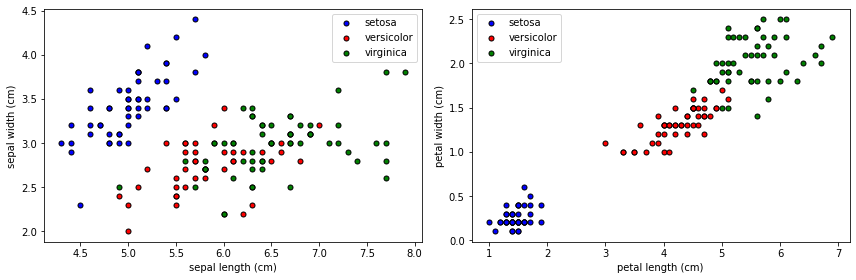

In [19]:
# Plot data
plot_iris(X, y, data.feature_names, data.target_names, axis=0)

In [20]:
# Split data in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, shuffle=True, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105, 4), (45, 4), (105,), (45,))

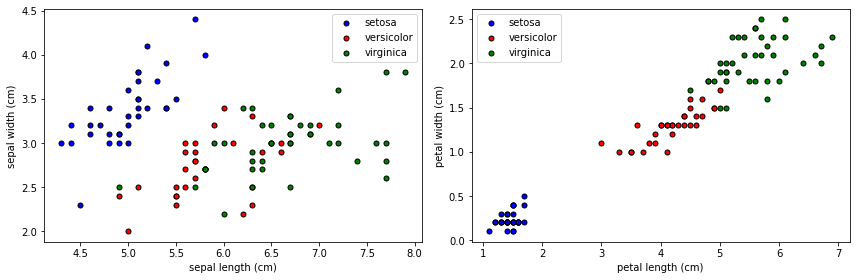

In [21]:
# Plot training data
plot_iris(X_train, y_train, data.feature_names, data.target_names, axis=0)

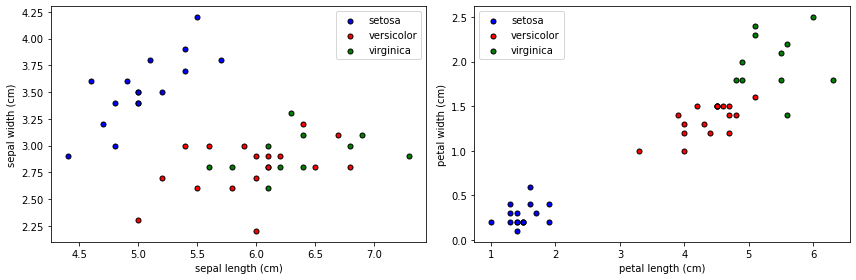

In [22]:
# Plot test data
plot_iris(X_test, y_test, data.feature_names, data.target_names, axis=0)

In [23]:
# Normalize training and test set
scaler =  MinMaxScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# Show mean and variance of the cross val scores
scores.mean(), scores.std()

(0.9857142857142858, 0.04285714285714287)

In [24]:
# Train k-nearest neighbors
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train_norm, y_train)

# Prdict labels
y_pred = knn.predict(X_test_norm)

# Show scores
knn.score(X_test_norm, y_test)

0.9777777777777777

In [25]:
# Paramter grid for knn
param_grid = {
    'n_neighbors': [x for x in range(1,11)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
# Train grid search cross validation model
grid_search = GridSearchCV(knn, param_grid, cv=10).fit(X_train_norm, y_train)

# Show best estimator
grid_search.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=10)

In [28]:
# Show score of best estimator
grid_search.best_score_

0.9618181818181819

In [29]:
def conf_mat(y_test, y_pred, target_names=None):
    """Plot confusion matrix as heatmap.
    
    Parameters
    ----------
        y_test : ndarray of shape (n_samples,)
            Test labels.
        y_pred : ndarray of shape (n_samples,)
            Predicted labels.
        target_names : list of strings
            Names of the labels.
    """
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), target_names,
                         target_names)
    sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='g')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

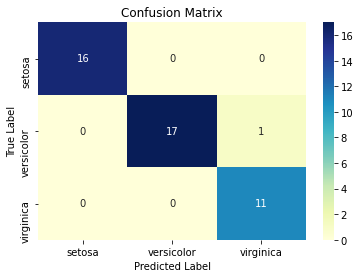

In [30]:
# Get prdictions with best estimator
y_pred = grid_search.best_estimator_.predict(X_test_norm)

# Plot confusion matrix as heatmap
conf_mat(y_test, y_pred, data.target_names)

# Digits dataset

<Figure size 432x288 with 0 Axes>

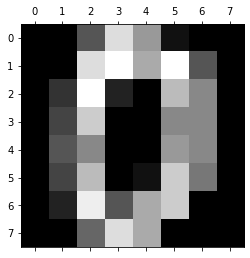

In [31]:
# Load digits dataset
data = load_digits()

# Plot example digit
plt.gray() 
plt.matshow(data.images[0]) 
plt.show()

In [32]:
# Get data X and class labels y
X = data.data
y = data.target
X.shape, y.shape

((1797, 64), (1797,))

In [33]:
# Print example
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [34]:
# Split data in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, shuffle=True, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((1257, 64), (540, 64), (1257,), (540,))

In [35]:
# Paramter grid for knn
param_grid = {
    'n_neighbors': [x for x in range(1,11)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Define grid search cross validation model
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, n_jobs=2)

# Build pipline 
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('grid_search', grid_search)
])

# Train pipeline
pipe.fit(X_train, y_train)

# Show best estimator
pipe['grid_search'].best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=4, weights='distance')

In [36]:
# Show score of best estimator
pipe['grid_search'].best_score_

0.9864698412698413

In [37]:
# Predict labels
y_pred = pipe.predict(X_test)

# Show test score
accuracy_score(y_test, y_pred)

0.987037037037037

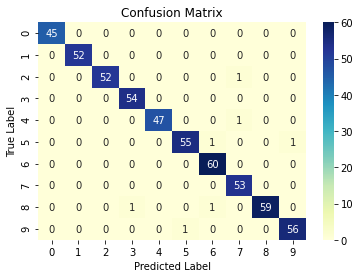

In [38]:
# Plot confusion matrix as heatmap
conf_mat(y_test, y_pred, data.target_names)

# Face recognition

In [39]:
from sklearn.datasets import fetch_lfw_people

In [69]:
# Load data
data = fetch_lfw_people(min_faces_per_person=100, resize=0.4)
 
# Get features (pictures) and labels (persons)
_, h, w = data.images.shape # h is height, w is width
X = data.data
y = data.target
X.shape, y.shape

((1140, 1850), (1140,))

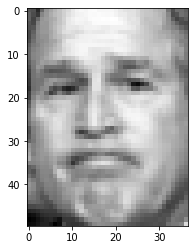

In [70]:
# Show example image
plt.imshow(X[0].reshape((h, w)), cmap=plt.cm.gray)

In [71]:
# Split data in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, shuffle=True, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((798, 1850), (342, 1850), (798,), (342,))

In [72]:
# Train pipeline from above
pipe.fit(X_train, y_train)

# Show best estimator
pipe['grid_search'].best_estimator_

/home/j/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')

In [73]:
# Show score of best estimator
pipe['grid_search'].best_score_

0.6843037974683546

In [74]:
# Predict labels
y_pred = pipe.predict(X_test)

# Show test score
accuracy_score(y_test, y_pred)

0.6783625730994152

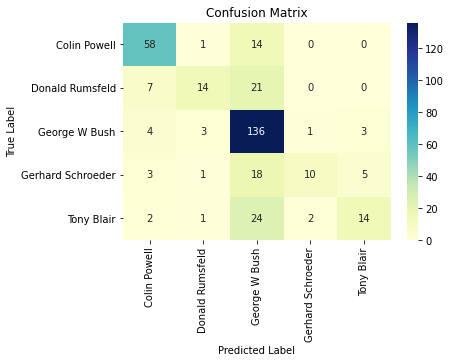

In [75]:
# Plot confusion matrix as heatmap
conf_mat(y_test, y_pred, data.target_names)